## Clustering Analysis

### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load the dataset
df = pd.read_csv('EastWestAirlines.csv')
df.head(5)# Display first few rows

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [9]:
df.shape

(3999, 12)

### Data Preprocessing
1. **Handle Missing Values and Outliers**: Remove rows with missing values and outliers.
2. **Scale the Features**: Standardize numeric features to have a mean of 0 and standard deviation of 1.

In [21]:
# Checking for missing values
df.isnull().sum()

ID#                    0
Balance                0
Qual_miles             0
cc1_miles              0
cc2_miles              0
cc3_miles              0
Bonus_miles            0
Bonus_trans            0
Flight_miles_12mo      0
Flight_trans_12        0
Days_since_enroll      0
Award?                 0
KMeans_Labels          0
Hierarchical_Labels    0
DBSCAN_Labels          0
dtype: int64

In [6]:
df[df.duplicated()]

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?


In [7]:
# Define function for detecting outliers using IQR for all the numerical columns
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to all numerical columns
def remove_outliers_all(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        df = remove_outliers(df, column)
    return df

# Apply the function to the entire dataframe
df_cleaned = remove_outliers_all(df)
df=df_cleaned

# Display the cleaned dataframe
df


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
5,6,16420,0,1,1,1,0,0,0,0,6942,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3990,4013,11310,0,1,1,1,5021,2,0,0,1409,0
3991,4014,39142,0,3,1,1,14981,28,0,0,1408,0
3992,4015,11181,0,1,1,1,929,12,0,0,1407,0
3993,4016,3974,0,1,1,1,365,3,0,0,1397,0


In [10]:
df.describe()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [11]:
# Scale the numeric features
scaler = StandardScaler()
numeric_features = ['Balance', 'Qual_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll']
df_scaled = scaler.fit_transform(df[numeric_features])


### Exploratory Data Analysis (EDA)
1. **Distribution of Features**: Plot histograms.
2. **Correlation Heatmap**: Identify correlations.

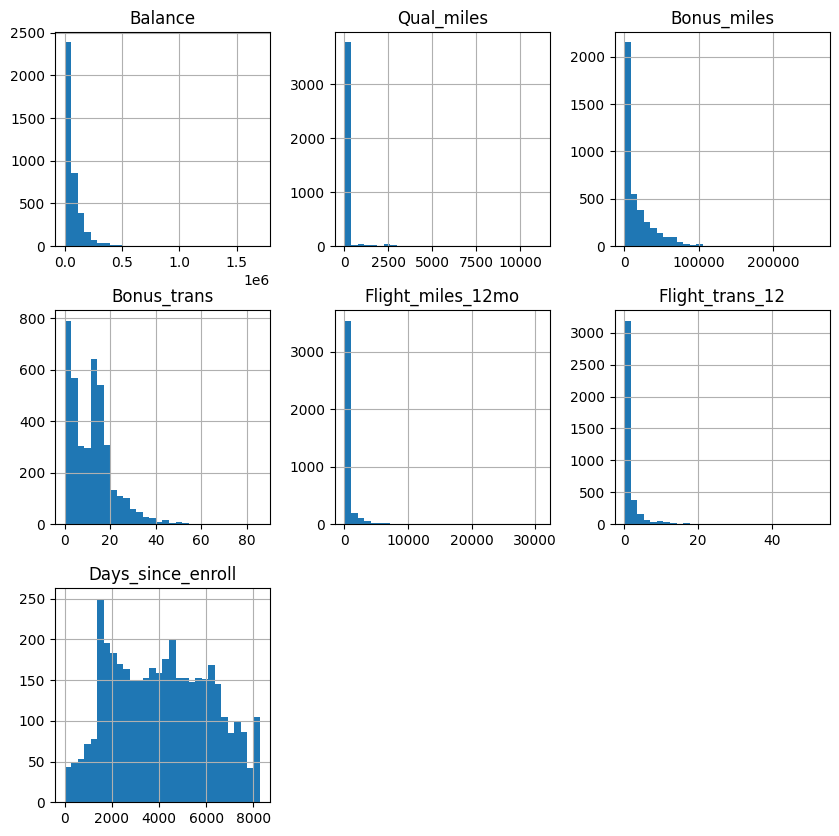

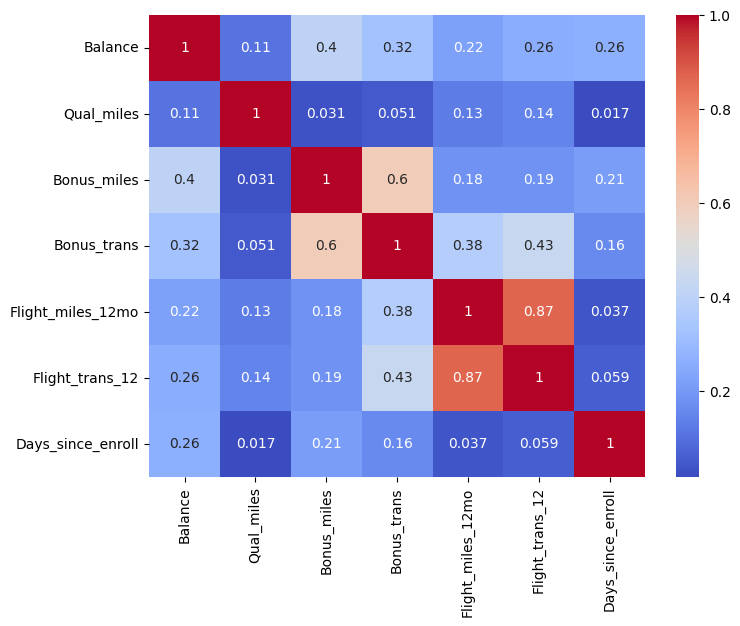

In [12]:
# Histograms
df[numeric_features].hist(bins=30, figsize=(10, 10))
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.show()

### Implementing Clustering Algorithms
1. **K-Means Clustering with Elbow Method**: Determine optimal `K`.
2. **Hierarchical Clustering**: Using different linkage criteria.
3. **DBSCAN Clustering**: Tune `epsilon` and `min_samples`.

#### K-Means Clustering

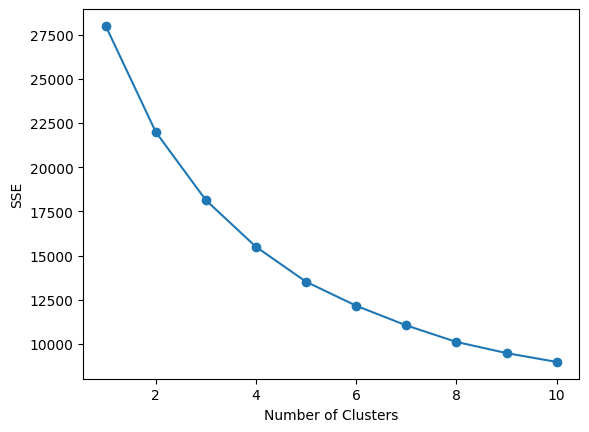

In [15]:
# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

# Apply K-Means with optimal K (e.g., K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Labels'] = kmeans.fit_predict(df_scaled)

#### Hierarchical Clustering

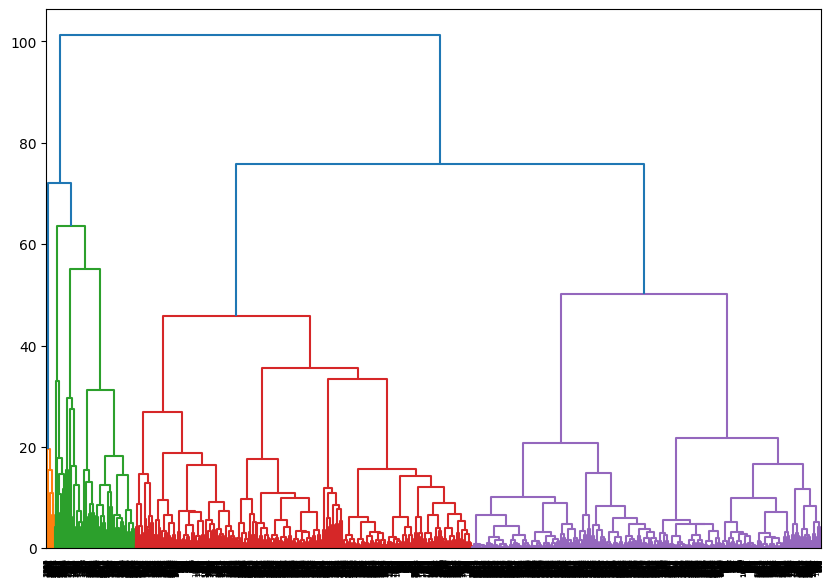

In [16]:
# Linkage and Dendrogram
linked = linkage(df_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.show()

# Apply Hierarchical Clustering with a threshold distance
df['Hierarchical_Labels'] = fcluster(linked, t=3, criterion='distance')

#### DBSCAN Clustering

In [17]:
# DBSCAN with specified epsilon and min_samples
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Labels'] = dbscan.fit_predict(df_scaled)

### Cluster Analysis and Interpretation
1. **Analyze Cluster Characteristics**: Use descriptive statistics.

In [18]:
# Cluster characteristics
print(df.groupby('KMeans_Labels')[numeric_features].mean())
print(df.groupby('Hierarchical_Labels')[numeric_features].mean())
print(df.groupby('DBSCAN_Labels')[numeric_features].mean())

                     Balance  Qual_miles   Bonus_miles  Bonus_trans  \
KMeans_Labels                                                         
0              195374.974359  799.717949  32590.314103    27.641026   
1               40242.614548   87.038995   5955.815523     7.133108   
2              133100.476190  186.585884  40471.080782    19.608844   

               Flight_miles_12mo  Flight_trans_12  Days_since_enroll  
KMeans_Labels                                                         
0                    5548.782051        16.224359        4617.878205  
1                     185.722160         0.563555        3580.883015  
2                     407.170068         1.240646        5271.696429  
                           Balance    Qual_miles   Bonus_miles  Bonus_trans  \
Hierarchical_Labels                                                           
1                     38110.333333  10440.000000   8605.666667    13.333333   
2                    163245.500000   8590.250000  20

### Visualization
**Scatter Plot for Clusters**: Use PCA for dimensionality reduction to 2D.

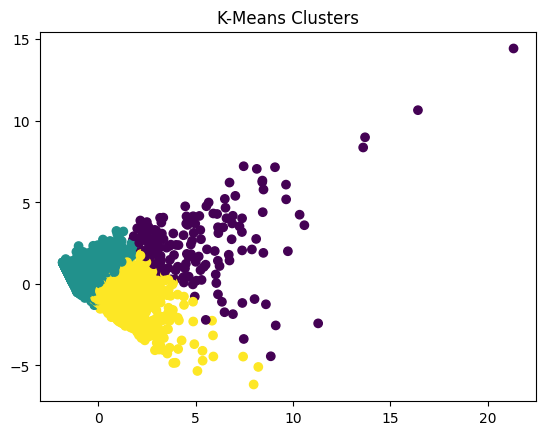

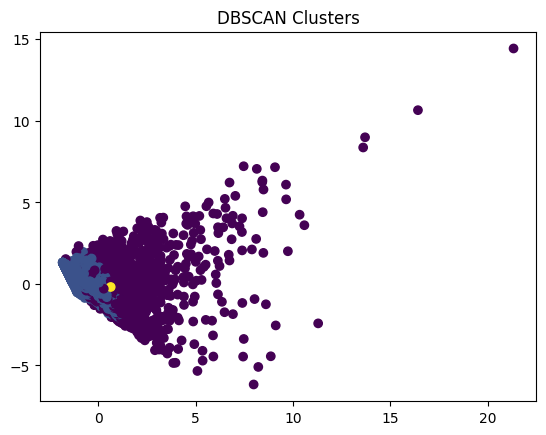

In [19]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Scatter plot for K-Means clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['KMeans_Labels'], cmap='viridis')
plt.title('K-Means Clusters')
plt.show()

# Scatter plot for DBSCAN clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['DBSCAN_Labels'], cmap='viridis')
plt.title('DBSCAN Clusters')
plt.show()

### Evaluation and Performance Metrics
1. **Silhouette Score**: Calculate for K-Means and DBSCAN.
2. **Davies-Bouldin Score**: Evaluate cluster separation.

In [20]:
# Silhouette Score for K-Means
silhouette_kmeans = silhouette_score(df_scaled, df['KMeans_Labels'])
print('K-Means Silhouette Score:', silhouette_kmeans)

# Silhouette Score for DBSCAN
silhouette_dbscan = silhouette_score(df_scaled, df['DBSCAN_Labels'])
print('DBSCAN Silhouette Score:', silhouette_dbscan)

# Davies-Bouldin Score for K-Means
davies_bouldin_kmeans = davies_bouldin_score(df_scaled, df['KMeans_Labels'])
print('K-Means Davies-Bouldin Score:', davies_bouldin_kmeans)

K-Means Silhouette Score: 0.31349249619062447
DBSCAN Silhouette Score: -0.013171408980990671
K-Means Davies-Bouldin Score: 1.3781862531139273
